Montar Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importamos librerias necesarias

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            precision_score, recall_score, f1_score, roc_curve, auc)
from tensorflow.keras.metrics import AUC, Precision, Recall

Path de dataset

In [57]:
# df_origa = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Glaucoma/ORIGA/origa_info.csv')
# df_origa['Glaucoma'] = df_origa['Glaucoma'].astype(str)

In [58]:
# df_g1020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Glaucoma/G1020/G1020.csv')
# df_g1020['Glaucoma'] = df_g1020['binaryLabels'].astype(str)
# df_g1020['Image'] = df_g1020['imageID']

In [59]:
# df_origa['Source'] = 'ORIGA'
# df_g1020['Source'] = 'G1020'

# root_origa = "/content/drive/MyDrive/Colab Notebooks/Glaucoma/ORIGA/Images"
# root_g1020 = "/content/drive/MyDrive/Colab Notebooks/Glaucoma/G1020/Images"

# # Filtrar columnas
# df_glacuoma = df_origa[['Source', 'Image', 'Glaucoma']].copy()

# # Aplicar la ruta correcta
# def get_image_path(row):
#     if row['Source'] == 'ORIGA':
#         return os.path.join(root_origa, row['Image'])
#     else:
#         return None
# # Crear columna 'Path'
# df_glacuoma['Path'] = df_glacuoma.apply(get_image_path, axis=1)

# df_glacuoma.head()

# CARGA DE DATOS - LOCAL

In [43]:
df_origa = pd.read_csv("./datos/ORIGA/origa_info.csv")
df_g1020 = pd.read_csv("./datos/G1020/G1020.csv")
df_refuge_train = pd.read_json("./datos/REFUGE/train/index.json", orient='index')
df_refuge_test = pd.read_json("./datos/REFUGE/test/index.json", orient='index') ## esta no tiene label

In [45]:
#Identifico la base
df_origa['Source'] = 'ORIGA'
df_g1020['Source'] = 'G1020'
df_refuge_train['Source'] = 'REFUGE' 

#Renombro columnas
df_g1020 = df_g1020.rename(columns={'imageID': 'Image','binaryLabels': 'Glaucoma'})
df_origa = df_origa.rename(columns={'Label': 'Glaucoma'})
df_refuge_train = df_refuge_train.rename(columns={'ImgName': 'Image','Label': 'Glaucoma'})

#Uno las bases
df_glacuoma = pd.concat([df_origa[['Image', 'Source', 'Glaucoma']]
                      ,df_g1020[['Image', 'Source', 'Glaucoma']]
                      #,df_refuge_train[['Image', 'Source', 'Glaucoma']]
                      #,df_icesi[['Image', 'Source', 'Glaucoma']]
                      ],
                      ignore_index=True)


conteo = df_glacuoma.groupby('Source').size().reset_index(name='Cantidad')
print(conteo)

df_glacuoma.head

  Source  Cantidad
0  G1020      1020
1  ORIGA       650


<bound method NDFrame.head of                Image Source  Glaucoma
0            001.jpg  ORIGA         0
1            002.jpg  ORIGA         0
2            003.jpg  ORIGA         0
3            004.jpg  ORIGA         0
4            005.jpg  ORIGA         0
...              ...    ...       ...
1665  image_3198.jpg  G1020         0
1666  image_3199.jpg  G1020         0
1667  image_3201.jpg  G1020         1
1668  image_3202.jpg  G1020         1
1669  image_2568.jpg  G1020         0

[1670 rows x 3 columns]>

Agregamos la ruta completa de la imagen al dataset

In [46]:

# Rutas diferentes para cada base de datos
root_origa = "./datos/ORIGA/Images"
root_g1020 = "./datos/G1020/Images"
root_refuge = "./datos/REFUGE/train/Images"


# Función para aplicar la ruta correcta
def get_image_path(row):
    if row['Source'] == 'ORIGA':
        return os.path.join(root_origa, row['Image'])
    elif row['Source'] == 'G1020':
        return os.path.join(root_g1020, row['Image'])
    elif row['Source'] == 'REFUGE':
        return os.path.join(root_refuge, row['Image'])
    elif row['Source'] == 'ICESI':
        return row['Image']
    else:
        return None  # En caso de que no coincida con ninguna base

# Aplicar la función a cada fila para crear la columna 'Path'
df_glacuoma['Path'] = df_glacuoma.apply(get_image_path, axis=1)

# Verificar los resultados

df_glacuoma[df_glacuoma["Source"] == "REFUGE"].head()

,Image,Source,Glaucoma,Path


Partimos train y test

In [47]:
df_train, df_test = train_test_split(df_glacuoma, test_size=0.15, random_state=42, stratify=df_glacuoma['Glaucoma'])

In [48]:
df_train['Glaucoma'] = df_train['Glaucoma'].astype(str)
df_test['Glaucoma'] = df_test['Glaucoma'].astype(str)

In [49]:
print("Distribucion en entrenamiento:")
print(df_train['Glaucoma'].value_counts(normalize=True))

print("Distribucion en test:")
print(df_test['Glaucoma'].value_counts(normalize=True))

Distribucion en entrenamiento:
Glaucoma
0    0.72234
1    0.27766
Name: proportion, dtype: float64
Distribucion en test:
Glaucoma
0    0.721116
1    0.278884
Name: proportion, dtype: float64


Configuración de parámetros para DA y VGG16

In [50]:
width_shape = 224
height_shape = 224
num_classes = 2
epochs = 15
batch_size = 8

Generador de imágenes (entrenamiento y test)

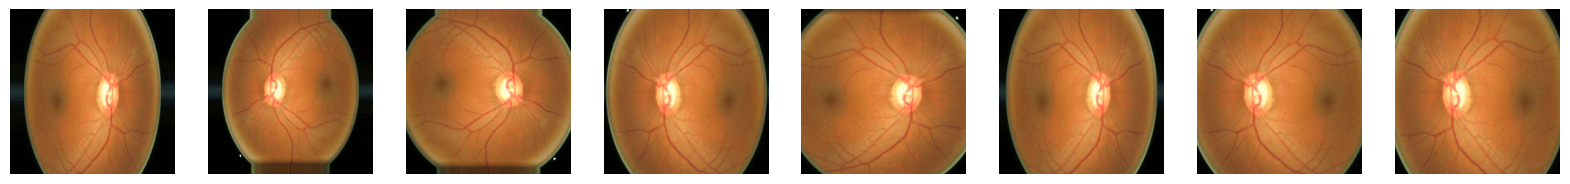

In [51]:
ruta_imagen = df_glacuoma['Path'].iloc[0]

# Cargar imagen, convertir a array y expandir dimensiones para simular batch
img = load_img(ruta_imagen, target_size=(width_shape, height_shape))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # shape (1, 224, 224, 3)

# Generador de visualización
vis_datagen = ImageDataGenerator(
    # rotation_range=50,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Mostrar imágenes aumentadas
plt.figure(figsize=(20,4))
i = 0
for batch in vis_datagen.flow(x, batch_size=1):
    plt.subplot(1, 8, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    i += 1
    if i >= 8:
        break
plt.show()

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1419 entries, 1600 to 642
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     1419 non-null   object
 1   Source    1419 non-null   object
 2   Glaucoma  1419 non-null   object
 3   Path      1419 non-null   object
dtypes: object(4)
memory usage: 55.4+ KB


In [53]:
train_datagen = ImageDataGenerator(
    # rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='Path',
    y_col='Glaucoma',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='Path',
    y_col='Glaucoma',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 1419 validated image filenames belonging to 2 classes.
Found 251 validated image filenames belonging to 2 classes.


Clases para tratar desbalanceo

In [54]:
classes = np.unique(df_train['Glaucoma'])

# Calcular pesos automáticos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=df_train['Glaucoma']
)

# Convertir a diccionario
class_weights = dict(zip(classes, class_weights))

print("Pesos por clase:", class_weights)

Pesos por clase: {'0': np.float64(0.6921951219512195), '1': np.float64(1.8007614213197969)}


Entrenamiento de modelo VGG16

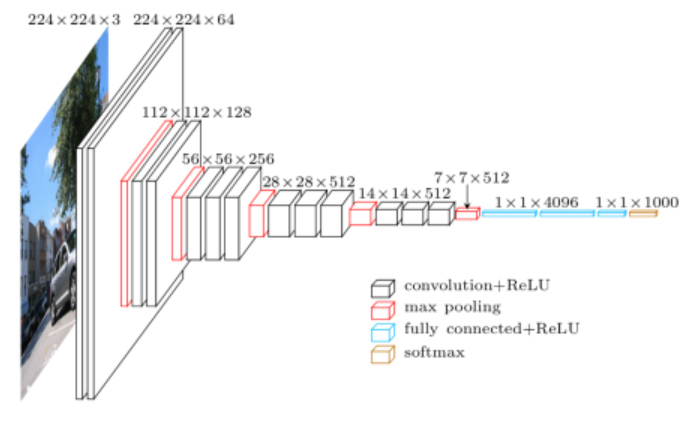

In [55]:
# Número de muestras
nb_train_samples = 552
nb_validation_samples = 98

# Cargar la base de VGG16 sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas de la base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas para la clasificación
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predicciones = Dense(1, activation='sigmoid')(x)

# Definir el modelo completo
vgg16_model = Model(inputs=base_model.input, outputs=predicciones)

# Compilar el modelo
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),
               loss='binary_crossentropy',
               metrics=['binary_accuracy',AUC(),Precision(), Recall()])
vgg16_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [56]:
# Entrenamiento del modelo
model_history = vgg16_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_steps=nb_validation_samples // batch_size,
    class_weight=class_weights
)

/Users/gome33773/Documents/MIAA-ICESI-ProyectoIA/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - auc_1: 0.5653 - binary_accuracy: 0.6185 - loss: 4.4953 - precision_1: 0.3807 - recall_1: 0.4011 - val_auc_1: 0.5366 - val_binary_accuracy: 0.6250 - val_loss: 1.9541 - val_precision_1: 0.2857 - val_recall_1: 0.1333
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - auc_1: 0.5242 - binary_accuracy: 0.6207 - loss: 2.2685 - precision_1: 0.2497 - recall_1: 0.2366 - val_auc_1: 0.6192 - val_binary_accuracy: 0.7083 - val_loss: 0.8829 - val_precision_1: 0.3333 - val_recall_1: 0.0769
Epoch 3/15
40/69 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - auc_1: 0.5370 - binary_accuracy: 0.6467 - loss: 1.1288 - precision_1: 0.2217 - recall_1: 0.1610

/Users/gome33773/Documents/MIAA-ICESI-ProyectoIA/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 855ms/step - auc_1: 0.5344 - binary_accuracy: 0.6376 - loss: 1.1300 - precision_1: 0.2366 - recall_1: 0.1813 - val_auc_1: 0.6015 - val_binary_accuracy: 0.6250 - val_loss: 0.6740 - val_precision_1: 0.3750 - val_recall_1: 0.3000
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - auc_1: 0.5905 - binary_accuracy: 0.6501 - loss: 0.8218 - precision_1: 0.4160 - recall_1: 0.3090 - val_auc_1: 0.6001 - val_binary_accuracy: 0.7083 - val_loss: 0.5924 - val_precision_1: 0.4545 - val_recall_1: 0.1852
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - auc_1: 0.5257 - binary_accuracy: 0.6783 - loss: 0.6829 - precision_1: 0.2529 - recall_1: 0.0994 - val_auc_1: 0.6329 - val_binary_accuracy: 0.7188 - val_loss: 0.5846 - val_precision_1: 1.0000 - val_recall_1: 0.0357
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 46s 658ms/step - auc_1: 0.6351 - binary_accuracy: 0.6816 - loss: 0.6851 - precision_1: 0.5619 - recall_1: 0.1388 - val_auc_1: 0.6730 - val_binary_accuracy: 0.6667 - val_los

Gráficas de entrenamiento y validación (accuracy - loss)

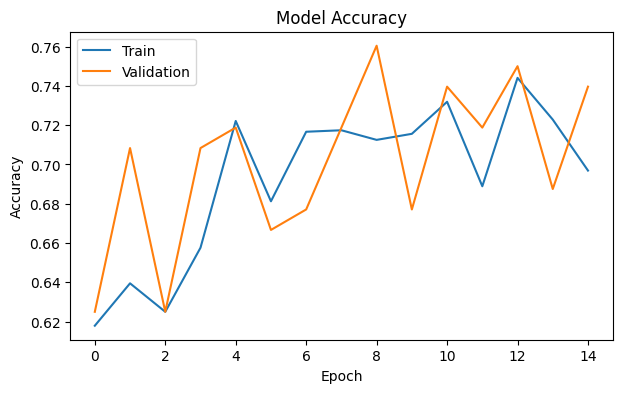

In [60]:
plt.figure(figsize=(7,4))
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

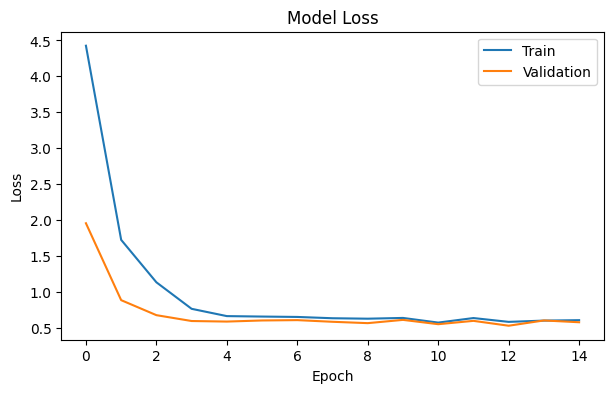

In [61]:
plt.figure(figsize=(7,4))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


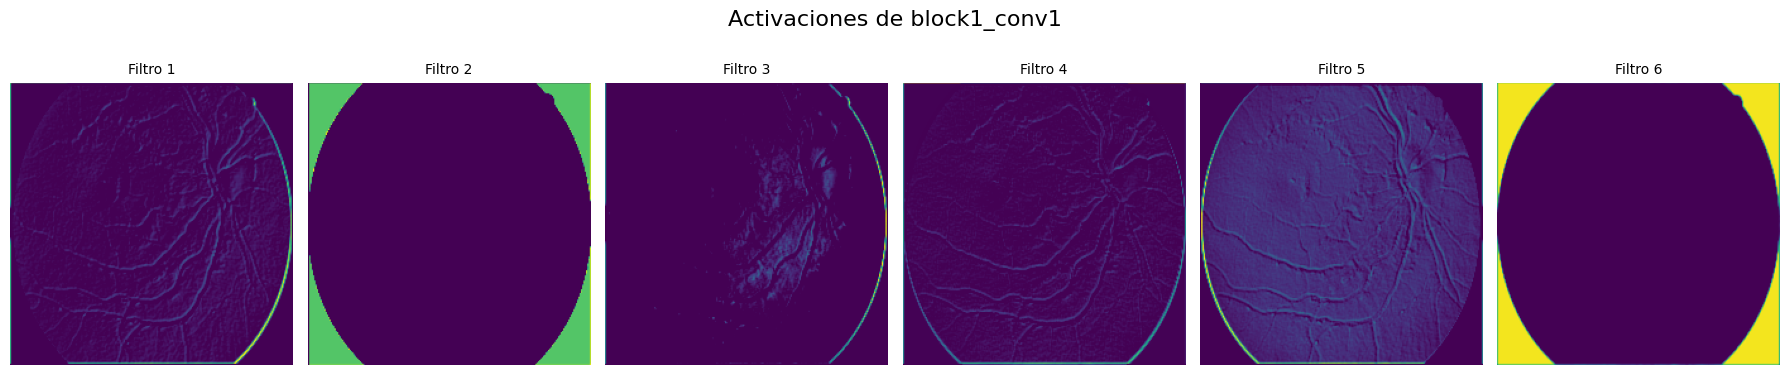

In [63]:
# 1. Cargar imagen aleatoria
img_path = df_train['Path'].iloc[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 2. Modelo intermedio
layer_name = 'block1_conv1'
# layer_name = 'block2_conv2'
# layer_name = 'block3_conv3'
# layer_name = 'block5_conv3'
intermediate_layer_model = Model(inputs=vgg16_model.input,
                                 outputs=vgg16_model.get_layer(layer_name).output)

# 3. Activaciones
feature_maps = intermediate_layer_model.predict(img_array)

# 4. Visualización en una sola fila
num_filters = 6
plt.figure(figsize=(3 * num_filters, 4))  # Ajusta el tamaño horizontal dinámicamente

for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filtro {i+1}', fontsize=10)

plt.suptitle(f'Activaciones de {layer_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # deja espacio para el título
plt.show()


In [64]:
from sklearn.metrics import balanced_accuracy_score
# Suavizar las probabilidades y etiquetas
y_proba = vgg16_model.predict(test_generator).reshape(-1)
y_true = test_generator.classes

# Buscar el mejor threshold según F1
thresholds = np.linspace(0, 1, 1000)
f1s = [balanced_accuracy_score(y_true, y_proba > t) for t in thresholds]
# f1s = [f1_score(y_true, y_proba > t) for t in thresholds]
best_th = thresholds[np.argmax(f1s)]

# Aplicar mejor threshold
y_pred = (y_proba > best_th).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step


In [66]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Reporte de clasificación:\n", classification_report(y_true, y_pred))

Accuracy: 0.32270916334661354
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.08      0.14       181
           1       0.29      0.96      0.44        70

    accuracy                           0.32       251
   macro avg       0.55      0.52      0.29       251
weighted avg       0.67      0.32      0.22       251



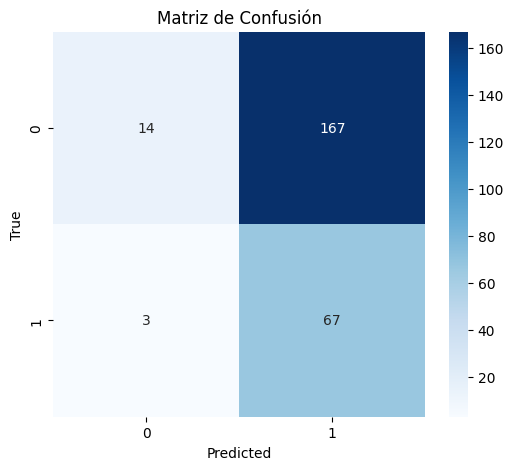

In [68]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

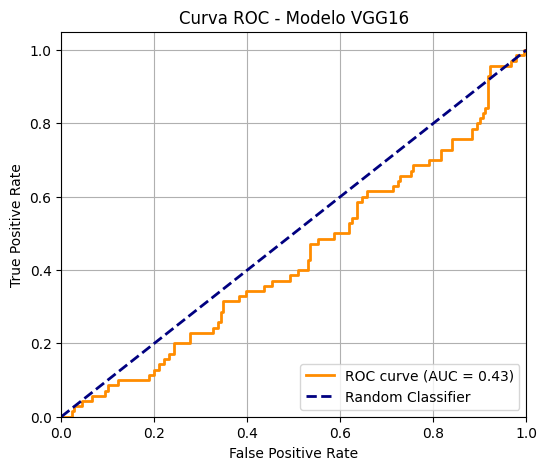

In [69]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo VGG16')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


/var/folders/mx/sjxkwhxj65g5pkzh_v8cwdp40000gp/T/ipykernel_58825/4024515053.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


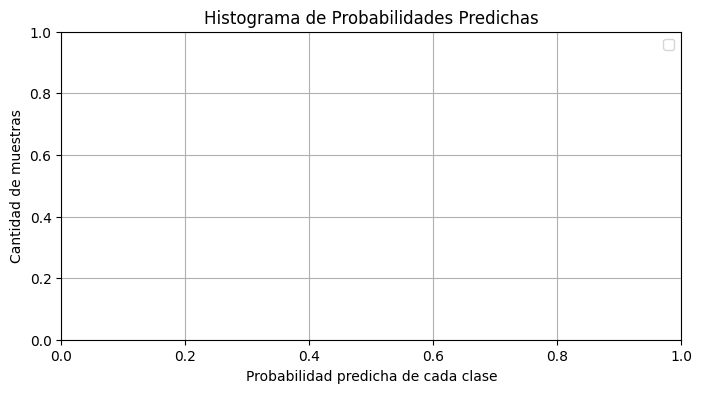

In [70]:
plt.figure(figsize=(8, 4))

data0 = y_proba[y_true == 0]
data1 = y_proba[y_true == 1]

if len(data0) > 0:
    plt.hist(data0, bins=25, alpha=0.6, color='red', label='Clase 0 (Negativa)')

if len(data1) > 0:
    plt.hist(data1, bins=25, alpha=0.6, color='green', label='Clase 1 (Positiva)')

plt.title('Histograma de Probabilidades Predichas')
plt.xlabel('Probabilidad predicha de cada clase')
plt.ylabel('Cantidad de muestras')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
